In [15]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead)
| YrFireName                  | A unique identifier for each fire event that includes the year and fire name; YEAR - Fire         
| Times_burned                | The number of times this tree was burned                                             
| Species                     | First two letters of genus and species. 2TREE = unknown tree species                               
| Genus_species               | Genus and species of tree                                     
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

/tmp/ipykernel_1222671/1765753220.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


In [3]:
# Filter to variables of interest
trees_dat = trees_dat[["yr1status", "YrFireName", "Times_burned", "Species", "Genus_species", "DBH_cm", "HT_m", "CR_pre", "CR_post"]]

# Look at the df 
print(trees_dat.head())

# Count observations before dropping NA
number_obs = trees_dat.shape[0]

# Remove rows containing NA
trees_dat = trees_dat.dropna()

# Count observations after dropping NA
number_obs_post = trees_dat.shape[0]

print(f"Removing rows containing NAs removed {number_obs - number_obs_post} rows, leaving us with {number_obs_post} observations.")

   yr1status     YrFireName  Times_burned Species Genus_species  DBH_cm  \
0        1.0  2006 - Tripod             1   2TREE       Unknown  26.416   
1        1.0  2006 - Tripod             1   2TREE       Unknown   1.270   
2        1.0  2006 - Tripod             1   2TREE       Unknown  25.400   
3        1.0  2006 - Tripod             1   2TREE       Unknown   8.382   
4        1.0  2006 - Tripod             1   2TREE       Unknown  21.844   

    HT_m  CR_pre  CR_post  
0  21.03     NaN      NaN  
1   2.13    0.29      NaN  
2  18.29     NaN      NaN  
3  14.33    0.38      NaN  
4  11.89     NaN      NaN  
Removing rows containing NAs removed 133334 rows, leaving us with 36509 observations.


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [4]:
# Check data types
trees_dat.dtypes

yr1status        float64
YrFireName        object
Times_burned       int64
Species           object
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object

In [5]:
# Recode categorical predictors
for col in ['YrFireName', 'Species', 'Genus_species']:
    trees_dat[f"{col}_cat"] = trees_dat[col].astype('category').cat.codes

In [6]:
# Look at the df
trees_dat.head()

,yr1status,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post,YrFireName_cat,Species_cat,Genus_species_cat
500,0.0,2003 - Griff,1,ABAM,Abies_amabilis,71.374,41.76,0.84,0.74,37,0,0
501,0.0,2003 - Griff,1,ABAM,Abies_amabilis,23.622,12.80,0.60,0.57,37,0,0
502,0.0,2003 - Griff,1,ABAM,Abies_amabilis,46.228,34.75,0.75,0.59,37,0,0
503,0.0,2003 - Griff,1,ABAM,Abies_amabilis,21.082,23.16,0.38,0.38,37,0,0
504,0.0,2003 - Griff,1,ABAM,Abies_amabilis,24.384,26.21,0.42,0.42,37,0,0


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [10]:
# Assign predictor and outcome variables 
X = trees_dat.drop(['yr1status', 'YrFireName', 'Species', 'Genus_species'], axis = 1)
y = trees_dat['yr1status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Scale training features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [11]:
# Verify the training and testing set size
print("Training set observations:", X_train_scaled.shape[0])
print("Testing set observations:", X_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [12]:
# Create a fit Logistic Regression classifier
classifier = LogisticRegression().fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = classifier.predict(X_train_scaled)

# Assess accuracy 
score = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {score}")

Training Accuracy: 0.945061825011739


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.913722267871816


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


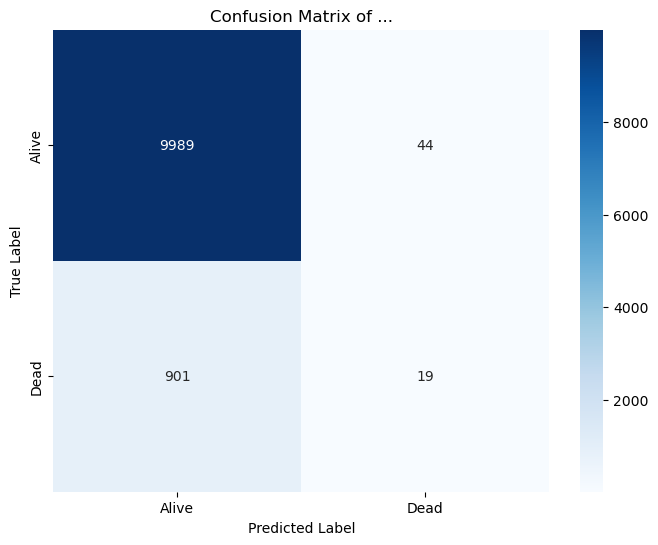

In [23]:
# Make test predictions
y_test_pred = classifier.predict(X_test)

# Assess accuracy 
score2 = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Accuracy: {score2}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm, fmt = 'd', cmap = 'Blues', xticklabels = ['Alive', 'Dead'],
               yticklabels = ['Alive', 'Dead'], annot = True)
plt.title('Confusion Matrix of ...')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

*Your answer here*

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

*Your answer here*

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [ ]:
...

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: ")
print("\nDummy Confusion Matrix:")


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [ ]:
# Logistic classifier AUC
...
print(f"Logistic AUC: ")

In [ ]:
# Dummy classifier AUC
...
print(f"Dummy AUC: ")

# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

*Your answer here*

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [ ]:
...

# Print the sorted feature importance
print(importance_df)

Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

*Your answer here*